In [1]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import itertools
from scipy.io import savemat,loadmat
from scipy import linalg
from sklearn.manifold import TSNE
import math
import random
from scipy.ndimage import convolve1d


C:\Users\2357638D\.conda\envs\pytorch\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: [WinError 126] The specified module could not be found
  warn(f"Failed to load image Python extension: {e}")


In [2]:
'''Initialize the parameters'''
num_inputs = 48
resSize = 10
num_outspk = num_inputs*resSize
num_outputs = 1
#tau_n = 1
#C = 10e-6
#R = tau_n/C
#tau_r = tau_n/8
tau_r1 = 1e-3
R1 = 5
C1 = 3e-3
trh1 = 0.5

tau_r2 = 2e-3
R2 = 5
C2 = 5e-3
trh2 = 0.3

# initialize LIF neurons
lif1 = snn.Lapicque(R=R1, C=C1, time_step=tau_r1, threshold = trh1)
lif2 = snn.Lapicque(R=R2, C=C2, time_step=tau_r2, threshold = trh2)
lif = [lif1, lif2]
np.random.seed(42)
lif_index = np.random.randint(0,2,size = num_inputs)

In [24]:
#path = 's33_db2_exD.mat'
path = 's1_db2_rest_SNR30.mat'
signal = loadmat(path)
#print(signal.keys())
#data = signal['s_spk']
#target = signal['s_label']
data = signal['s_rest']
target = signal['s_rest_label']
#train_spike = signal['s1_spk']
#train_spike = data['trainset']
#traintarget = data['trainlabel']
#test_spike = data['testset']
#testtarget = data['testlabel']

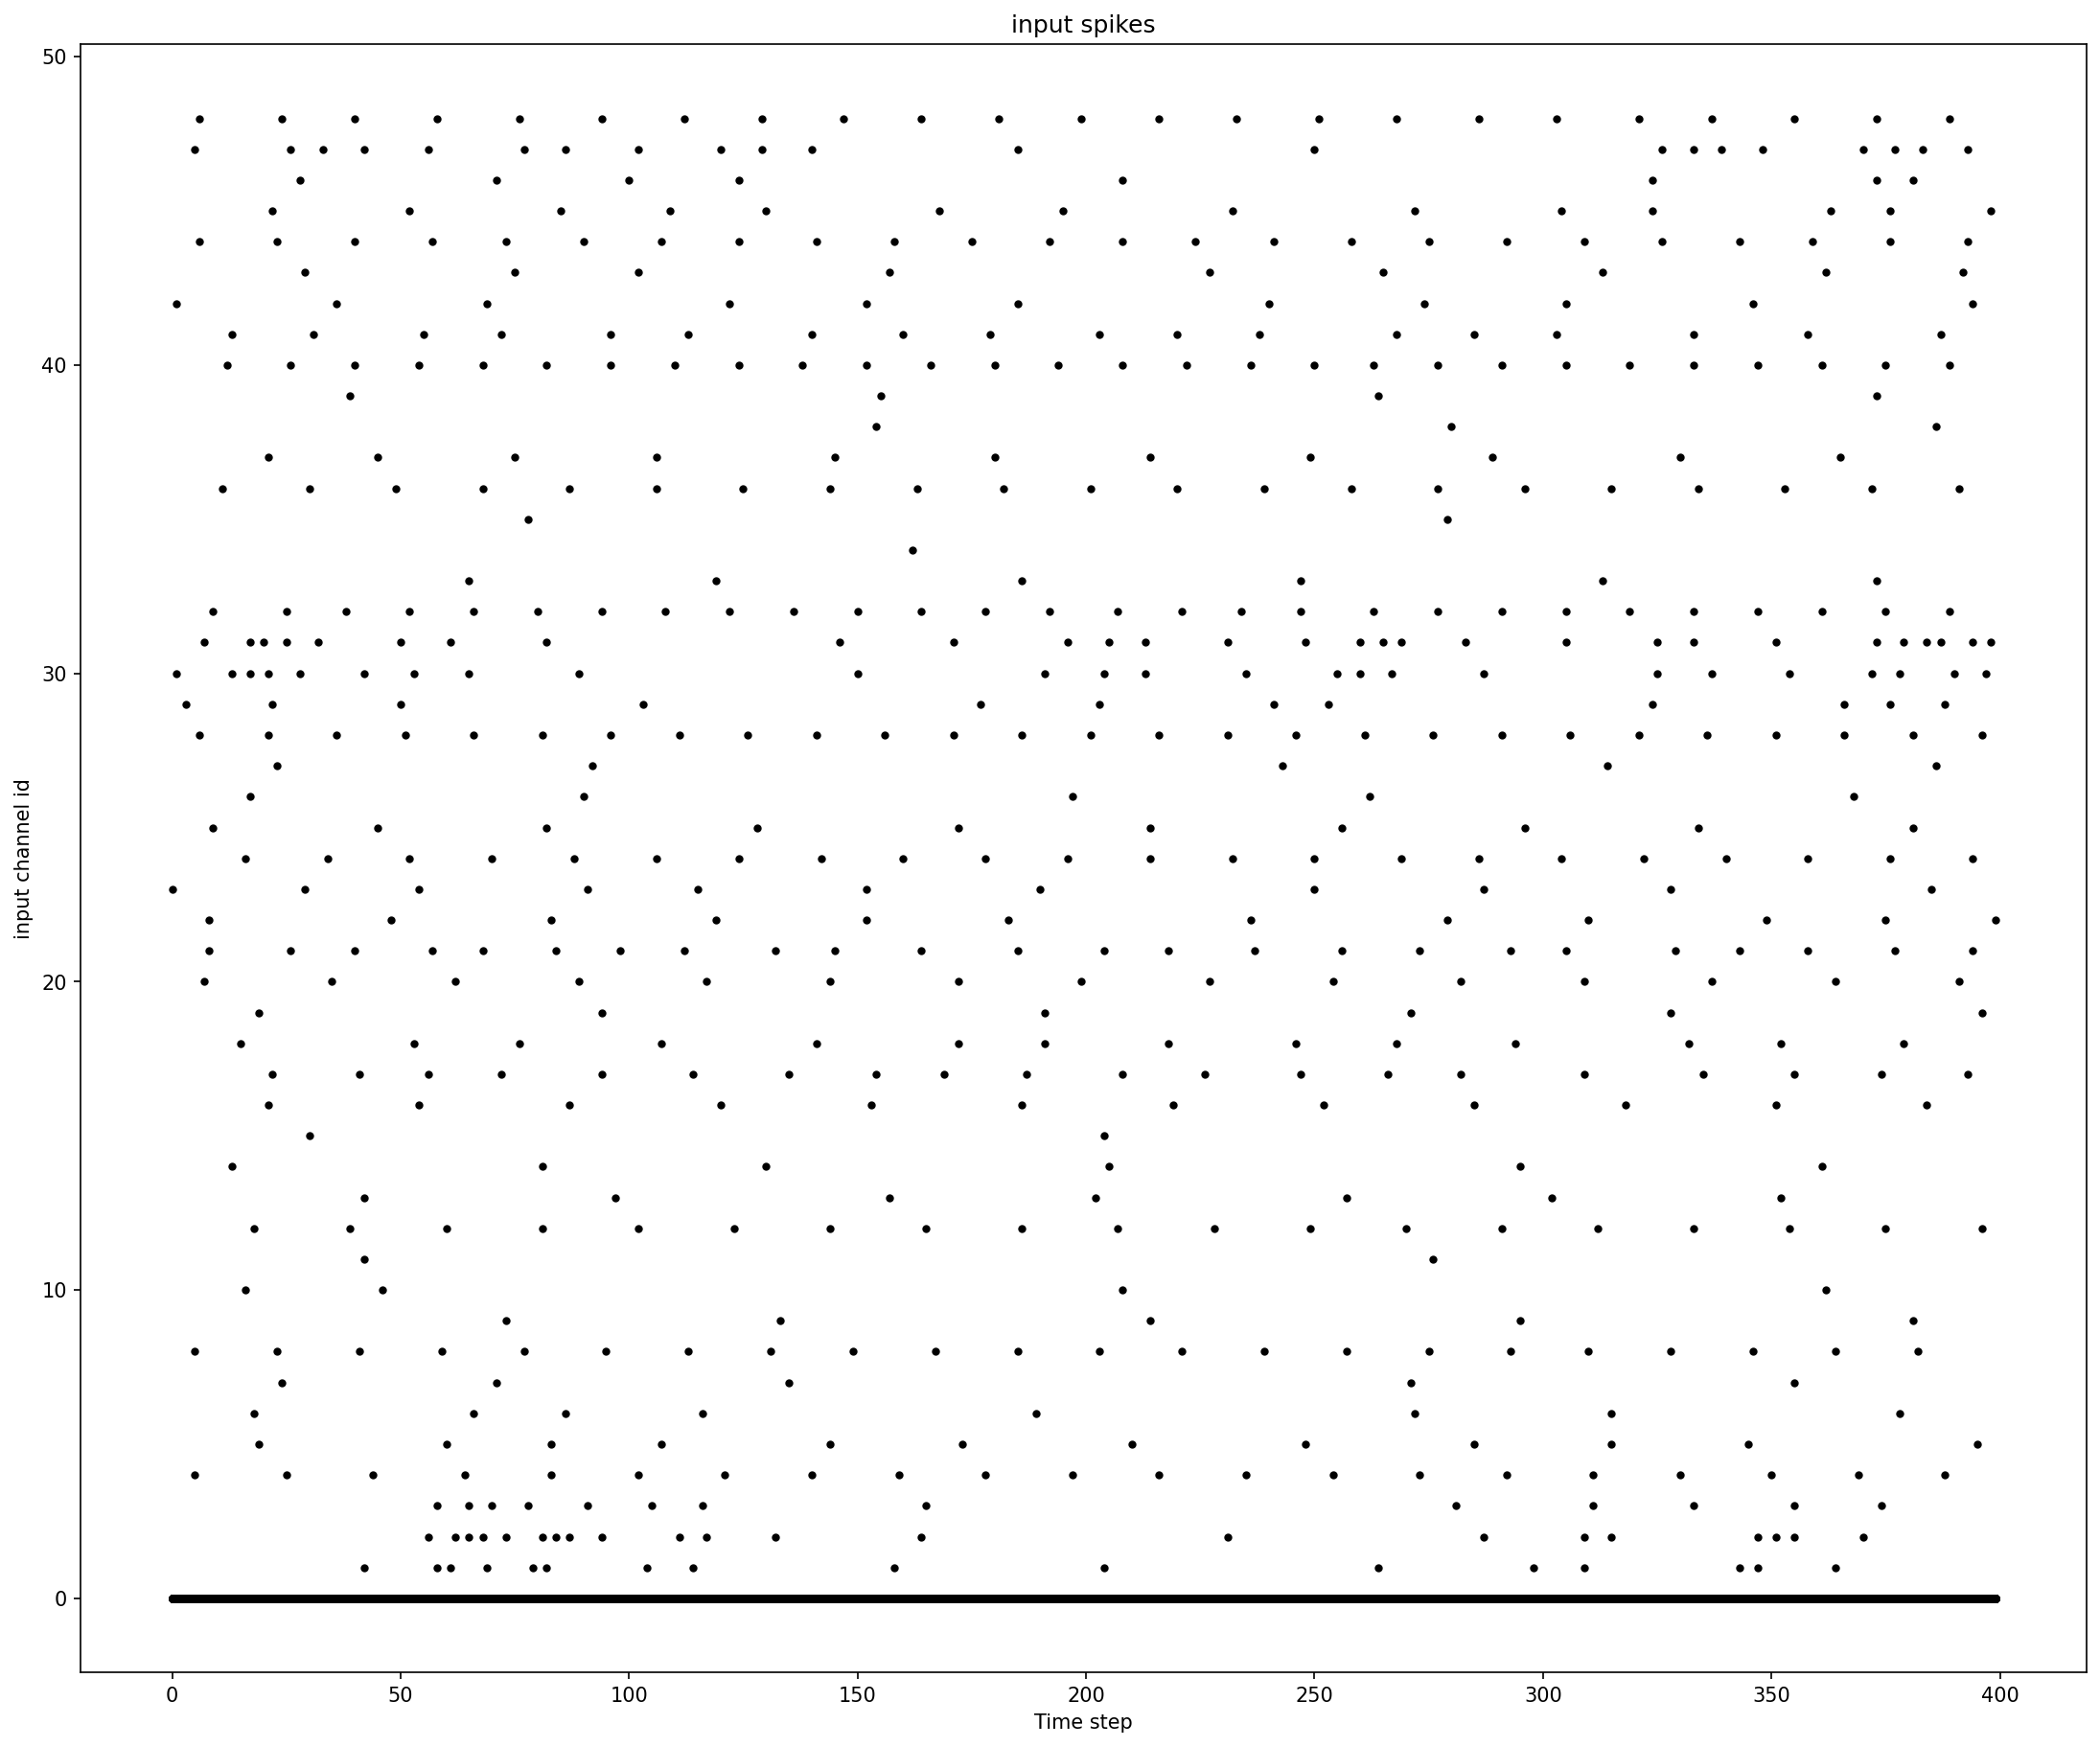

In [25]:
'''Take a look at the input spikes for different gestures'''
g1 = data[1,0]
'''g2 = data[25,0]
g3 = data[49,0]
g4 = data[73,0]
g5 = data[97,0]
g6 = data[121,0]
g7 = data[145,0]
g8 = data[168,0]
#g17 = data[385,0]
'''
plt.figure(figsize=(18,15), dpi=150)
for i in range(num_inputs):
    plt.plot((i+1)*g1[:,i],'.k')

plt.title("input spikes")
plt.xlabel("Time step")
plt.ylabel("input channel id")
plt.show()

In [26]:
'''define the sRNR network'''
def sRNR(spiketrain,resSize,lif):
    spiketrain = np.reshape(spiketrain,(len(spiketrain),-1))
    # input masking by randomly chosen {-1,1} 
    #Win  = np.random.randint(0,2,size = (1,resSize))*2 -1
    np.random.seed(42)
    Win  = np.random.randint(0,2,size = (1,resSize))
    
    #Win  = np.random.uniform(0, 1, (1,resSize))
    dataMask = np.dot(spiketrain,Win) 
    dataMask = np.transpose(dataMask)
    num_steps = dataMask.shape[1]  
    dataShifted = np.zeros((resSize, num_steps))
    for i in range(num_steps):
        dataShifted[:,i] = np.roll(dataMask[:,i], i)
    cur_in = torch.tensor(dataShifted[:,:])
    mem = torch.zeros((1,resSize))
    spk_out = torch.zeros((1,resSize)) 
    mem_rec = [mem]
    spk_rec = [spk_out]
      
    for step in range(num_steps):
        spk_out, mem = lif(cur_in[:,step], mem)
        # Store recordings of membrane potential
        mem_rec.append(mem)
        spk_rec.append(spk_out)

    # convert the list of tensors into one tensor
    mem_rec = torch.stack(mem_rec)
    spk_rec = torch.stack(spk_rec)
    
    mem_rec = mem_rec.numpy()
    spk_rec = spk_rec.numpy()
    mem_rec =  mem_rec.squeeze()
    spk_rec = spk_rec.squeeze()
    #mem_rec = np.transpose(mem_rec)
    spk_rec = spk_rec.T
    
    sk = np.zeros((resSize,num_steps))
    
    for t in range(num_steps):
        sk[:,t] = np.roll(spk_rec[:,t],-t)
        
    sk_T = sk.T
    sk_T = torch.from_numpy(sk_T)
    mem_rec = torch.from_numpy(mem_rec)
    return sk_T,mem_rec

In [27]:
'''spikes injected to the reservoir and receive the genereted output spikes'''
#L = 200*500
#data_spk = np.zeros((80,L))
num_sample = num_outputs*24
data_spk = np.zeros((num_sample,400,num_outspk))
data_mem = np.zeros((num_sample,401,num_outspk))
for j in range(len(data)):
    spike = data[j,0]
    spk = torch.zeros(0)
    mem = torch.zeros(0)
    for k in range(num_inputs):
        spiketrain = spike[:,k]
        spk_rec, mem_rec = sRNR(spiketrain,resSize,lif[lif_index[num_inputs-1]])
        spk = torch.cat((spk,spk_rec), dim=1)
        mem = torch.cat((mem,mem_rec), dim=1)
    spk = spk.numpy()
    mem = mem.numpy()
    #spk = spk.reshape(-1)
    #data_spk[j,:] = spk
    data_spk[j,:,:] = spk
    data_mem[j,:,:] = mem

In [28]:
'''define plot spikes function'''
def plt_spike(spiketrain,num_chs):
    plt.figure(figsize=(18,15), dpi=150)
    for i in range(num_chs):
        plt.plot((i+1)*spiketrain[:,i],'.k')

    plt.title("output spikes")
    plt.xlabel("Time step")
    plt.ylabel("neuron id")
    plt.show()

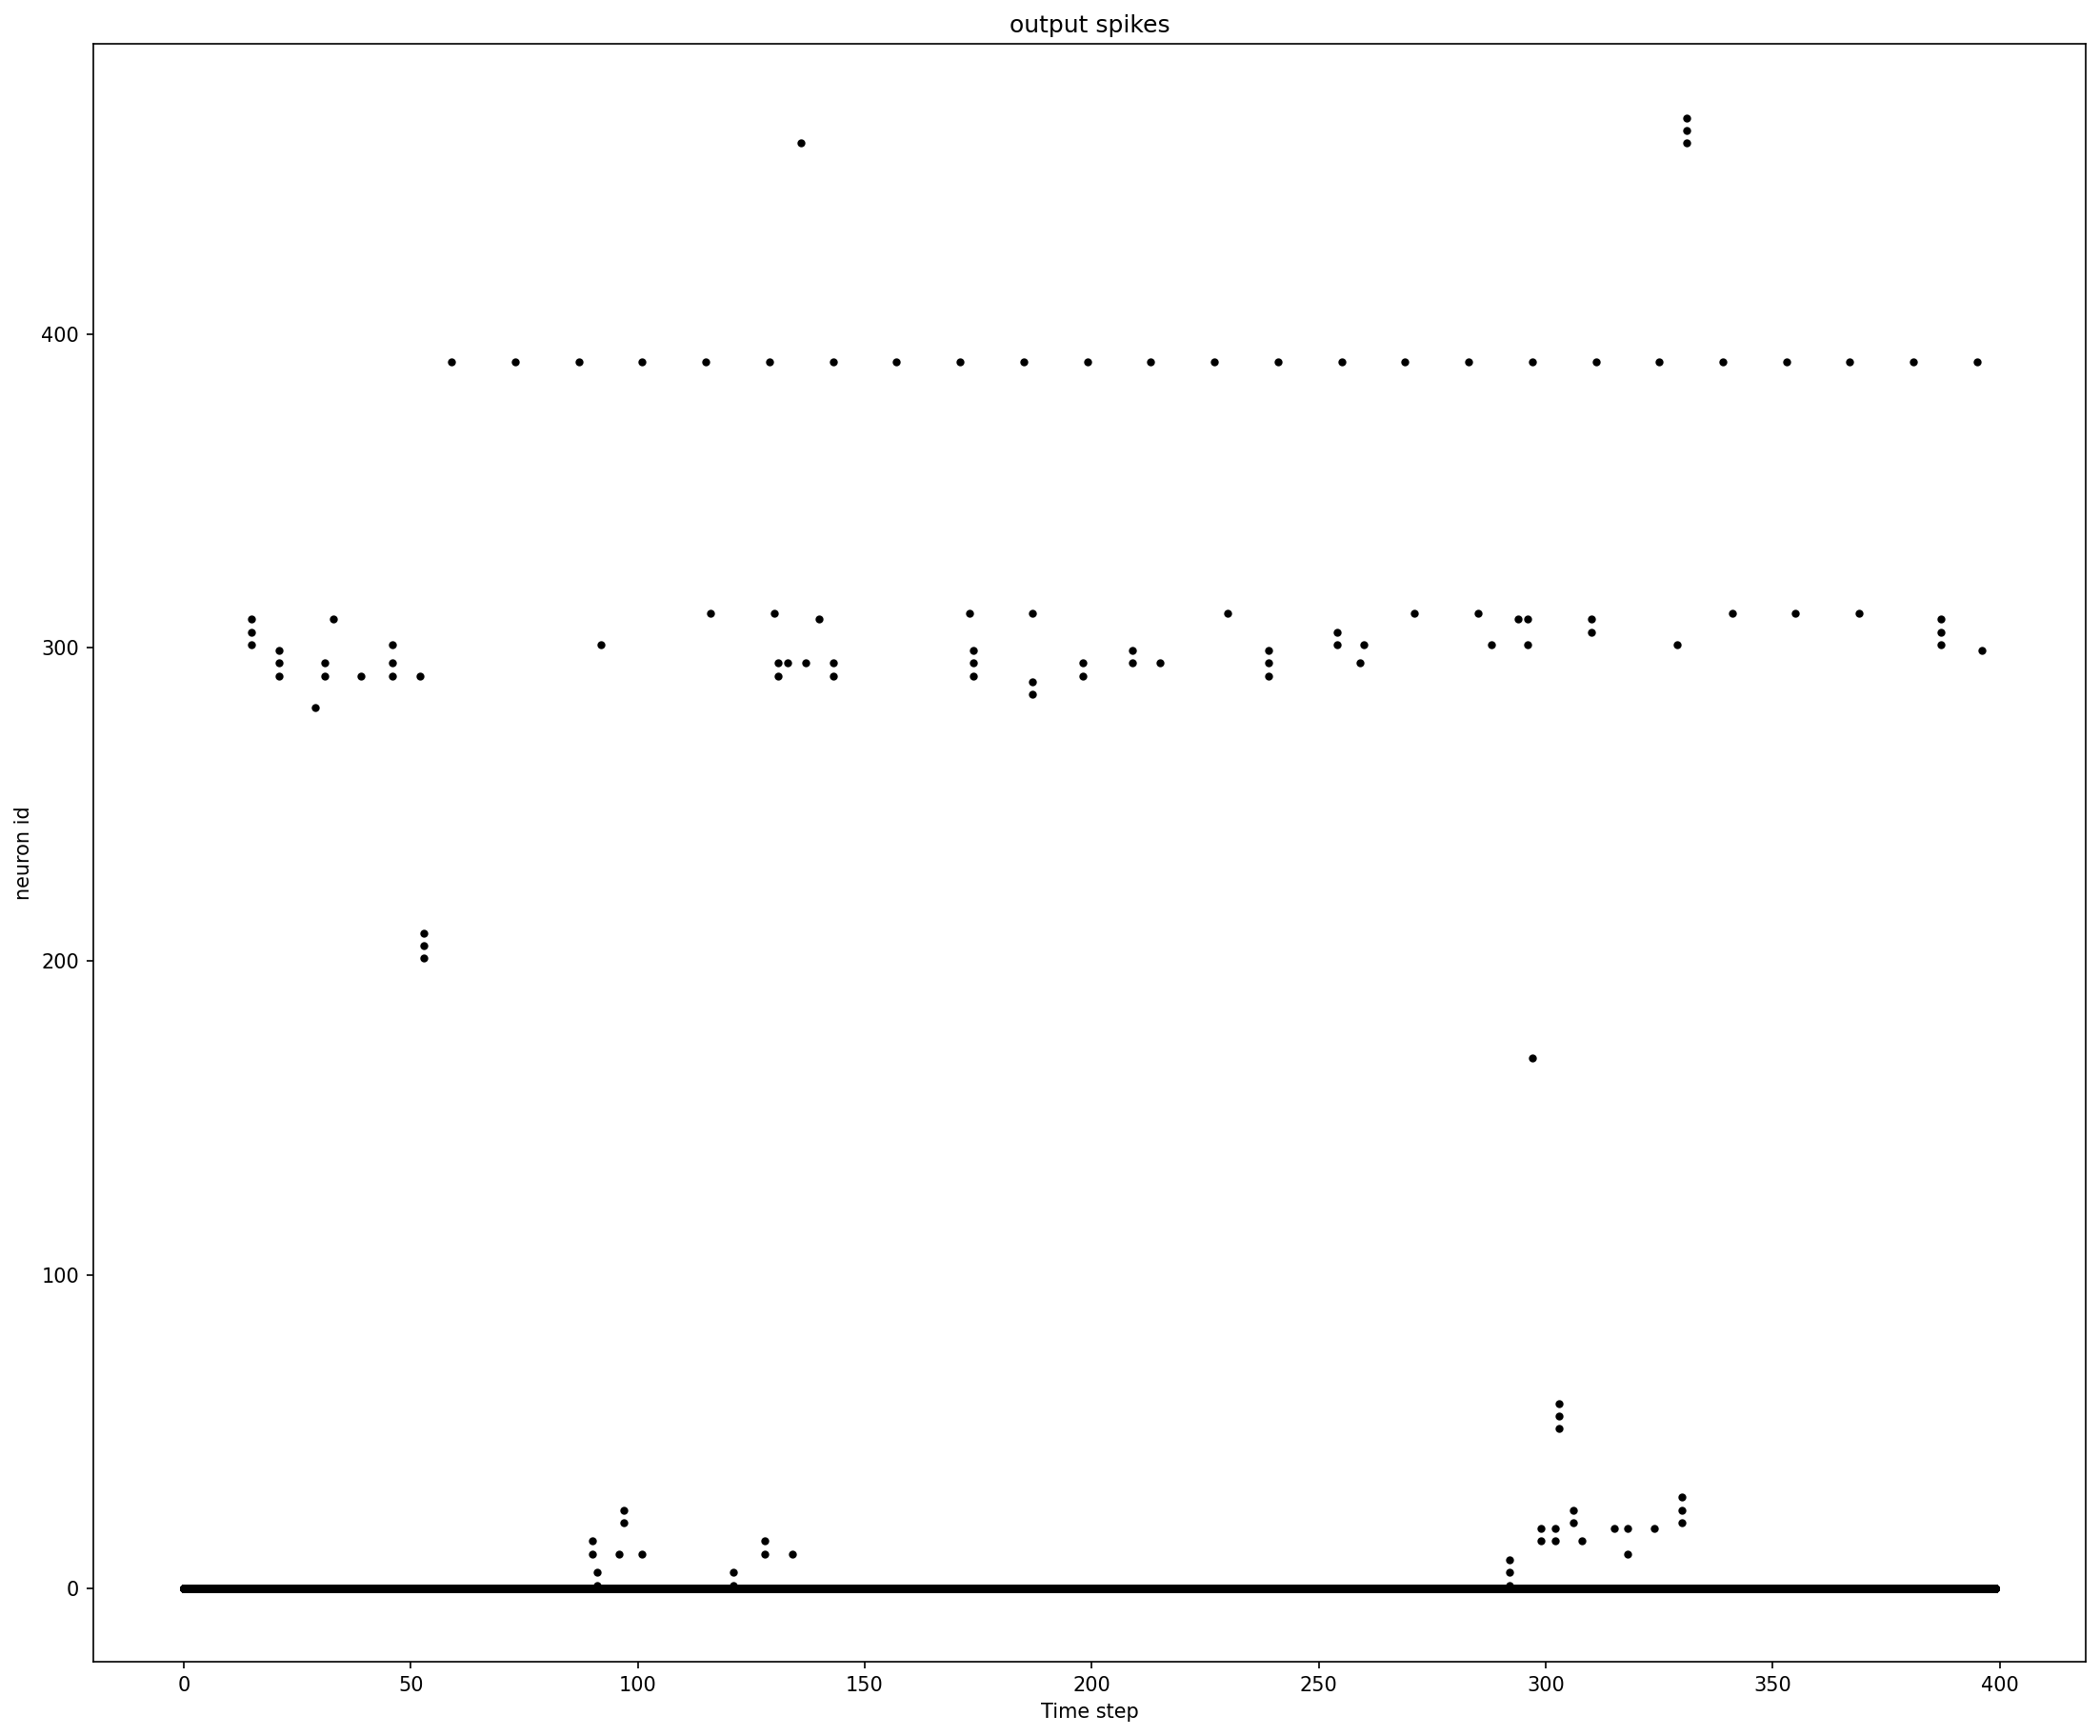

In [29]:
'''plot the output spikes after the reservoir'''
out_spk_g1 = data_spk[2,:,:]
plt_spike(out_spk_g1,num_outspk)

In [30]:
#file_path = 's33_db2_response144_exD.mat'
file_path = 's1_db2_response480_rest_SNR30.mat'
response = {'spike': data_spk,'label': target } 
savemat(file_path, response)

In [12]:
file_path = 's1_db2_membranepotential.mat'
response = {'membrane_potential': data_mem,'label': target } 
savemat(file_path, response)

In [10]:
'''regression'''
reg = 1e-8 
resSize = 400
Wout = linalg.solve(np.dot(trainstates.T, trainstates) + reg * np.eye(resSize),
                    (np.dot(traintarget.T, trainstates)).T).T
#teststates = testspk
y_pred = np.dot(teststates,Wout.T)
plt.figure(figsize=(18,5))
plt.plot(y_pred[:,0:4])

NameError: name 'trainstates' is not defined

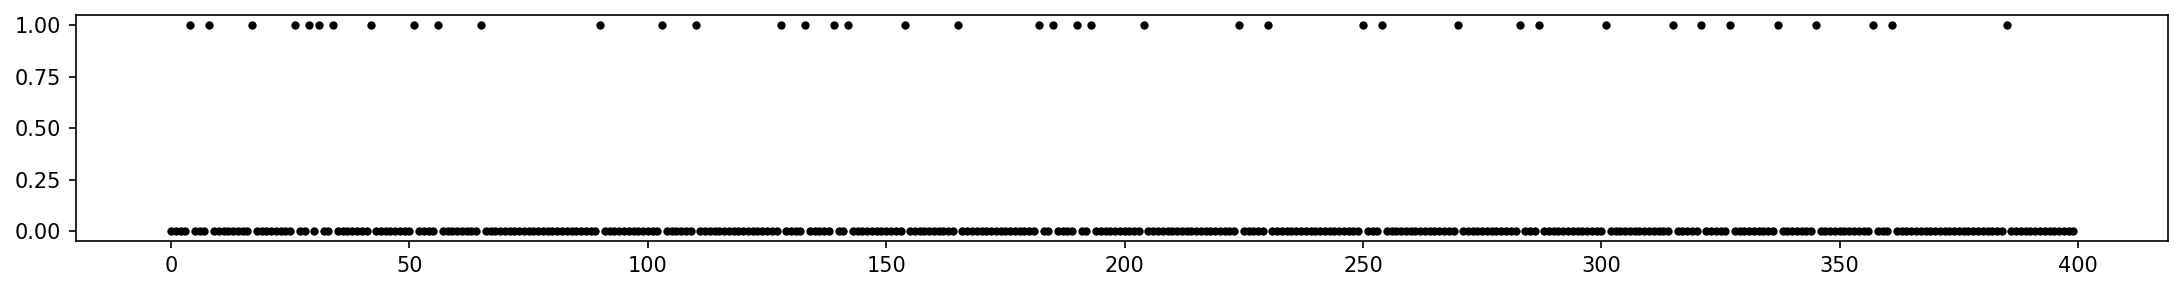

In [11]:
plt.figure(figsize=(18,2), dpi=150)
plt.plot(data_spk[169,:,125],'.k')

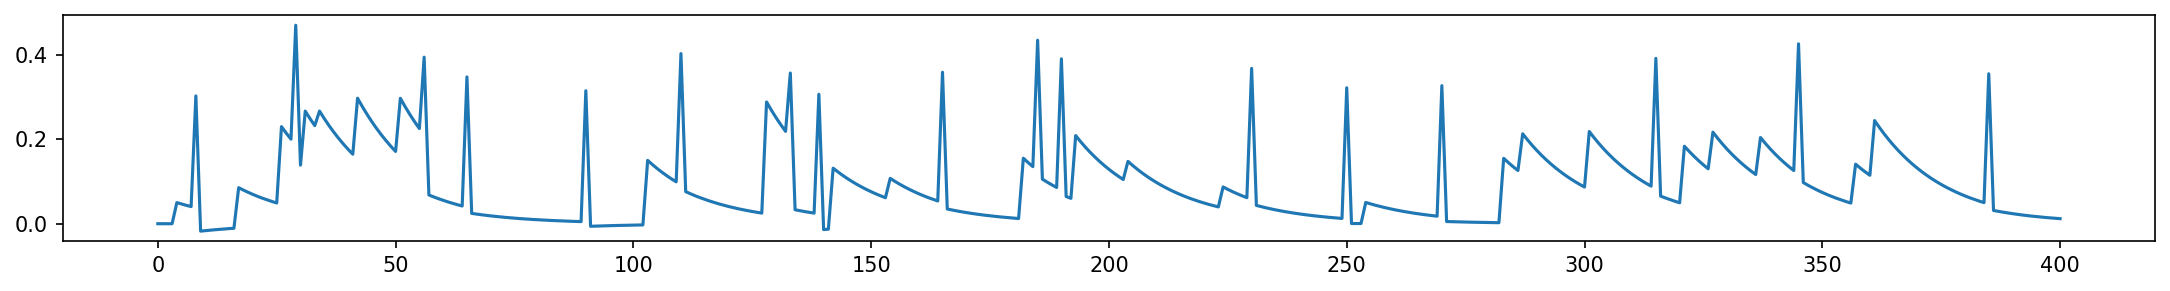

In [12]:
plt.figure(figsize=(18,2), dpi=150)
plt.plot(data_mem[169,:,125])

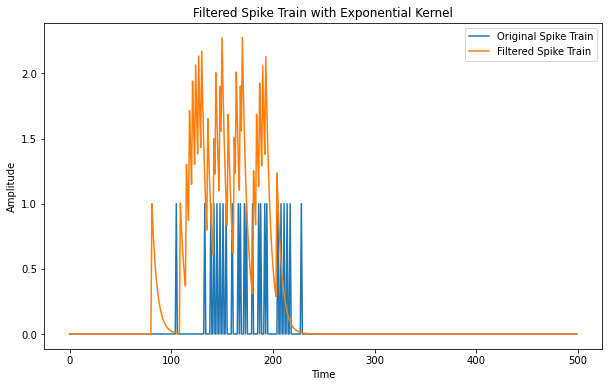

In [21]:
def exponential_kernel(t, tau):
    """
    Exponential kernel function.

    Parameters:
    - t: Time array.
    - tau: Time constant of the exponential decay.

    Returns:
    - Kernel values.
    """
    return np.exp(-t / tau)

def filter_spike_train(spike_train, tau):
    """
    Filter a spike train with an exponential kernel.

    Parameters:
    - spike_train: Binary array representing the presence of spikes.
    - tau: Time constant of the exponential decay.

    Returns:
    - Filtered spike train.
    """
    kernel_length = 10 * tau  # Length of the kernel, adjust as needed
    kernel_time = np.arange(0, kernel_length, 1)
    kernel = exponential_kernel(kernel_time, tau)
    
    filtered_spikes = np.convolve(spike_train, kernel, mode='same')

    return filtered_spikes

# Generate synthetic spike train data
spike_train_length = 500
spike_train = data_spk[70,:,:]

# Set parameters
tau = 5  # Time constant of the exponential decay

# Filter spike train
filtered_spikes = filter_spike_train(spike_train, tau)

# Plot original and filtered spike trains
plt.figure(figsize=(10, 6))
plt.plot(spike_train, label='Original Spike Train')
plt.plot(filtered_spikes, label='Filtered Spike Train')
plt.title('Filtered Spike Train with Exponential Kernel')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [6]:
import numpy as np

# Example training data (input vectors and corresponding target outputs)
X_train = np.array([[0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0]])
y_train = np.array([1.0, 2.0, 2.5, 3.5])

# Initialize weights and bias
np.random.seed(0)
weights = np.random.randn(2)
bias = np.random.randn()

# Learning rate
eta = 0.01

# Number of epochs
epochs = 1000

# Training loop
for epoch in range(epochs):
    for i in range(len(X_train)):
        # Compute output
        x = X_train[i]
        y = np.dot(weights, x) + bias
        
        # Compute error
        error = y - y_train[i]
        
        
        # Update weights and bias
        weights -= eta * error * x
        bias -= eta * error

print("Trained weights:", weights)
print("Trained bias:", bias)

# Predicting with the trained model
X_test = np.array([2.5, 3.5])
y_pred = np.dot(weights, X_test) + bias
print("Prediction for input [2.5, 3.5]:", y_pred)
print('loss:',error)

Trained weights: [ 1.76420939 -0.16397506]
Trained bias: 0.41444867610076624
Prediction for input [2.5, 3.5]: 4.251059455102806
loss: -0.05704385100540943


In [7]:
data_spk.shape

(80, 500, 400)

[[0 0 1 1 0 1 1 1 0 0]]
